In [ ]:
# Cài đặt thư viện PSO
!pip install pyswarms

import glob
import os
import pandas as pd
import numpy as np
import pyswarms as ps
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

# CẤU HÌNH
DATASET_FOLDER_PATH = '/content/drive/My Drive/Colab Notebooks/Model_on_pi/data/raw/CSE-CIC-IDS2018' # Sửa đường dẫn của bạn
SAMPLE_PER_FILE = 50000 # Giữ nguyên yêu cầu 50k mẫu/file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_and_clean_data(folder_path, sample_size):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))

    processed_frames = []

    # Các cột cần loại bỏ (Định danh, Tĩnh, Dư thừa)
    cols_to_drop = [
        'Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp',
        'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd URG Flags', 'CWE Flag Count',
        'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
        'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
        'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
        'Fwd Header Length.1'
    ]

    print(f"Bắt đầu xử lý {len(all_files)} files (Lấy mẫu: {sample_size}/file)...")

    for file in all_files:
        try:
            # Đọc file
            df = pd.read_csv(file, low_memory=False)
            df.columns = df.columns.str.strip() # Xóa khoảng trắng tên cột

            # --- LOGIC LẤY MẪU 50.000 ---
            if len(df) > sample_size:
                df_sampled = df.sample(n=sample_size, random_state=42)
            else:
                df_sampled = df

            # Sơ chế nhanh từng phần để giảm RAM
            # 1. Xóa cột rác ngay lập tức
            existing_cols = [c for c in cols_to_drop if c in df_sampled.columns]
            df_sampled = df_sampled.drop(columns=existing_cols)

            # 2. Xử lý NaN/Inf [cite: 157]
            df_sampled = df_sampled.replace([np.inf, -np.inf], np.nan).dropna()

            processed_frames.append(df_sampled)
            print(f"Đã xử lý: {os.path.basename(file)} | Shape: {df_sampled.shape}")

            del df # Giải phóng RAM

        except Exception as e:
            print(f"Lỗi đọc file {file}: {e}")

    # Gộp dữ liệu
    if processed_frames:
        combined_df = pd.concat(processed_frames, ignore_index=True)
        print(f"Tổng kích thước dữ liệu sau gộp: {combined_df.shape}")
        return combined_df
    else:
        return None

# --- THỰC THI ---
df = load_and_clean_data(DATASET_FOLDER_PATH, SAMPLE_PER_FILE)

# Tách X và y
if df is not None and 'Label' in df.columns:
    X = df.drop('Label', axis=1)
    y = df['Label']

    # Mã hóa nhãn (Label Encoding)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)
    print("Classes found:", le.classes_)
else:
    print("Lỗi dữ liệu hoặc không tìm thấy cột Label")

📂 Đang quét thư mục: /content/drive/My Drive/Colab Notebooks/Model_on_pi/data/raw/CSE-CIC-IDS2018
🚀 Bắt đầu xử lý 14 files (Lấy mẫu: 50000/file)...
   ✅ Đã xử lý: DoS attacks-Slowloris.csv | Shape: (36754, 71)
   ✅ Đã xử lý: DDOS attack-LOIC-UDP.csv | Shape: (5784, 71)
   ✅ Đã xử lý: Brute Force -XSS.csv | Shape: (734, 71)
   ✅ Đã xử lý: SQL Injection.csv | Shape: (286, 71)
   ✅ Đã xử lý: Brute Force -Web.csv | Shape: (2073, 71)
   ✅ Đã xử lý: DoS attacks-GoldenEye.csv | Shape: (50000, 71)
   ✅ Đã xử lý: DoS attacks-SlowHTTPTest.csv | Shape: (50000, 71)
   ✅ Đã xử lý: Bot.csv | Shape: (50000, 71)
   ✅ Đã xử lý: DDOS attack-HOIC.csv | Shape: (50000, 71)
   ✅ Đã xử lý: Infilteration.csv | Shape: (50000, 71)
   ✅ Đã xử lý: FTP-BruteForce.csv | Shape: (50000, 71)
   ✅ Đã xử lý: DoS attacks-Hulk.csv | Shape: (50000, 71)
   ✅ Đã xử lý: DDoS attacks-LOIC-HTTP.csv | Shape: (50000, 71)
   ✅ Đã xử lý: SSH-Bruteforce.csv | Shape: (50000, 71)
🧩 Đang ghép nối dữ liệu...
📊 Tổng kích thước dữ liệu sa

In [ ]:
print("Đang chạy Feature Selection với PSO...")

# Lấy mẫu nhỏ để chạy PSO cho nhanh (ví dụ 20k dòng từ tổng dữ liệu)
# Không cần chạy trên toàn bộ hàng triệu dòng để tìm feature
X_pso, _, y_pso, _ = train_test_split(X, y_encoded, train_size=20000, stratify=y_encoded, random_state=42)

# Hàm Fitness (Mục tiêu: Tăng Accuracy, Giảm số lượng Feature)
def f_per_particle(m, alpha=0.9):
    if np.count_nonzero(m) == 0:
        return 1.0

    X_subset = X_pso.iloc[:, m == 1]

    # Dùng RandomForest nhẹ để đánh giá
    clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=42)
    clf.fit(X_subset, y_pso) # Train trên tập mẫu
    acc = clf.score(X_subset, y_pso) # Test nhanh (hoặc chia split nhỏ hơn nếu muốn chuẩn)

    # Cost function
    n_features = X_subset.shape[1]
    total_features = X_pso.shape[1]
    j = (alpha * (1.0 - acc)) + ((1.0 - alpha) * (n_features / total_features))
    return j

def f(x):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i] > 0.5) for i in range(n_particles)]
    return np.array(j)

# Cấu hình PSO
n_particles_pso = 15 # Define n_particles for PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': n_particles_pso, 'p': 1} # Thêm 'k' và 'p'
dimensions = X.shape[1]
optimizer = ps.discrete.BinaryPSO(n_particles=n_particles_pso, dimensions=dimensions, options=options)

# Chạy tối ưu hóa (iters=10 để demo, tăng lên 20-30 nếu muốn kỹ hơn)
cost, pos = optimizer.optimize(f, iters=15)

# Lấy danh sách đặc trưng đã chọn
selected_indices = np.where(pos == 1)[0]
SELECTED_FEATURES = X.columns[selected_indices].tolist()

print(f"PSO ĐÃ CHỌN {len(SELECTED_FEATURES)} ĐẶC TRƯNG QUAN TRỌNG NHẤT:")
print(SELECTED_FEATURES)

🤖 Đang chạy Feature Selection với PSO...


2025-11-21 15:58:54,253 - pyswarms.discrete.binary - INFO - Optimize for 15 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 15, 'p': 1}
pyswarms.discrete.binary: 100%|██████████|15/15, best_cost=0.0567
2025-11-21 16:02:48,704 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05671785714285718, best pos: [1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0]



✅ PSO ĐÃ CHỌN 26 ĐẶC TRƯNG QUAN TRỌNG NHẤT:
['Dst Port', 'Flow Duration', 'Tot Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Bwd Pkts/s', 'Pkt Len Max', 'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio', 'Fwd Byts/b Avg', 'Bwd Byts/b Avg', 'Bwd Blk Rate Avg', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Idle Mean']


In [ ]:
print("Chuẩn bị dữ liệu huấn luyện...")

# 1. Chỉ giữ lại các đặc trưng PSO đã chọn
X_final = X[SELECTED_FEATURES]

# 2. Chia tập Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 3. Chuẩn hóa Min-Max
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lưu scaler
joblib.dump(scaler, 'scaler.pkl')

# 4. Reshape cho LSTM (Samples, Timesteps=1, Features)
# ELSTM cần đầu vào 3 chiều
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# One-hot encoding cho label
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(f"Input Shape: {X_train_lstm.shape}")

🔄 Chuẩn bị dữ liệu huấn luyện...
Input Shape: (396504, 1, 26)


In [ ]:
def build_elstm_rnn(input_shape, num_classes):
    model = Sequential()

    # Layer 1: LSTM (Enhanced Layer) - Return Sequences = True để giữ dòng thông tin
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2: LSTM
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))

    # Layer 3: Dense
    model.add(Dense(units=64, activation='relu'))

    # Output Layer (Softmax)
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_elstm_rnn((1, len(SELECTED_FEATURES)), num_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,415 (525.06 KB)

 Trainable params: 134,159 (524.06 KB)

 Non-trainable params: 256 (1.00 KB)

🚀 Bắt đầu huấn luyện ELSTM-RNN...
Epoch 1/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - accuracy: 0.8118 - loss: 0.6213 - val_accuracy: 0.8815 - val_loss: 0.3106
Epoch 2/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.8795 - loss: 0.3208 - val_accuracy: 0.9060 - val_loss: 0.2466
Epoch 3/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.8966 - loss: 0.2704 - val_accuracy: 0.9095 - val_loss: 0.2329
Epoch 4/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9027 - loss: 0.2537 - val_accuracy: 0.9117 - val_loss: 0.2246
Epoch 5/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - accuracy: 0.9058 - loss: 0.2452 - val_accuracy: 0.9114 - val_loss: 0.2271
Epoch 6/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9083 - loss: 0.2380 - val_accuracy: 0.9121 - val_loss: 0.2231
Epoch 7/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9096 - loss: 0.2340 - val_accuracy: 0.9134 - val_loss: 0.2218
Epoch 8/20
6196/6196 ━━━━━━━━━━━━━━━━━━━━ 54s 9m

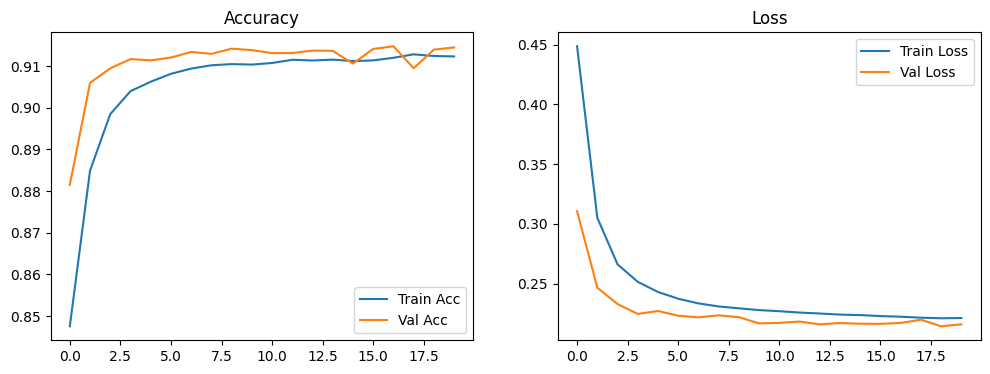

In [ ]:
print("Bắt đầu huấn luyện ELSTM-RNN...")

history = model.fit(
    X_train_lstm, y_train_onehot,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_lstm, y_test_onehot),
    verbose=1
)

# Đánh giá
print("Đánh giá mô hình...")
y_pred_prob = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

# Vẽ biểu đồ Loss/Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Lưu mô hình Keras gốc
model.save('model_elstm.keras')

# Chuyển đổi sang TFLite (Quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Thêm cấu hình để khắc phục lỗi TensorListReserve với LSTM
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('model_elstm.tflite', 'wb') as f:
    f.write(tflite_model)

print("Đã hoàn tất! Hãy tải các file sau về PC để đưa lên Raspberry Pi:")
print(f"1. model_elstm.tflite")
print(f"2. scaler.pkl")
print(f"3. Danh sách đặc trưng: {SELECTED_FEATURES}")

2025-11-21 16:25:01,880 - tensorflow - INFO - Assets written to: /tmp/tmppcvpog2e/assets


Saved artifact at '/tmp/tmppcvpog2e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 26), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  133861965016208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965019280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965018128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965015824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965016976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965018704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965016592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861965019088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861952799376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861952800912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133861952800720: Te